<a href="https://colab.research.google.com/github/javad-sheikh/CNN_Encoder_Decoder/blob/main/HW4_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import os
import re
import cv2
import pickle
import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import *
from tensorflow.python.keras.layers import *
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.metrics import log_loss
print(tf.__version__)

2.4.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')
root_path = 'drive/My Drive/ANN/HW4_CNN/'

Mounted at /content/drive


In [5]:
os.chdir('/content/drive/MyDrive/ANN/HW4_CNN')  #change dir

In [6]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip #download datasets
!tar -xvf BSR_bsds500.tgz #unzip file
!unzip data_semantics.zip

--2021-01-17 13:59:52--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.75.223
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.75.223|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327699796 (313M) [application/zip]
Saving to: ‘data_semantics.zip’

data_semantics.zip  100%[===================>] 312.52M  18.8MB/s    in 19s     

2021-01-17 14:00:12 (16.3 MB/s) - ‘data_semantics.zip’ saved [327699796/327699796]

tar: BSR_bsds500.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
Archive:  data_semantics.zip
   creating: testing/
   creating: testing/image_2/
  inflating: testing/image_2/000000_10.png  
  inflating: testing/image_2/000001_10.png  
  inflating: testing/image_2/000002_10.png  
  inflating: testing/image_2/000003_10.png  
  inflating: testing/image_2/000004_10.png  
  inflating:

In [10]:
%cd /content/drive/MyDrive/ANN/HW4_CNN

/content/drive/MyDrive/ANN/HW4_CNN


In [11]:
!ls

data_semantics.zip  HW4_CNN.ipynb  README.md  testing  training


In [12]:
path_train = 'training/image_2/'
path_ground_train = 'training/semantic_rgb/'
path_test = 'testing/image_2/'


In [13]:
def sort_load_image(folder):
  cv_img = []
  X = []
  print("image load|label semantic load")
  for img in glob.glob(folder + "*.png"):
    cv_img.append(img)
  cv_img.sort(key=lambda f: int(re.sub('\D', '', f)))
  dim = (1200, 320)
  for image in cv_img:
    n = cv2.resize(cv2.imread(image),dim, interpolation = cv2.INTER_AREA)
    X.append(n)

  return X

###load groundTruth###

In [14]:
X_train = sort_load_image(path_train)
X_train = np.array(X_train) 

Y_train = sort_load_image(path_ground_train) 
Y_train = np.array(Y_train)
# print(X_train[0].shape)

X_test = sort_load_image(path_test)
X_test = np.array(X_test) 


image load|label semantic load
image load|label semantic load
image load|label semantic load


(320, 1200, 3)


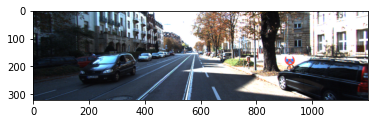

In [15]:
print(X_train[0].shape)
img_cvt=cv2.cvtColor(X_train[0], cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()

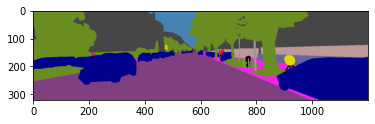

200


In [16]:
img_cvt=cv2.cvtColor(Y_train[0], cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()
print(len(Y_train))

In [17]:
f = []
for y in Y_train:
  f.append(len(np.unique(y)))
print(max(f))

256


In [18]:
Y_train[0][..., 0].max()
print(Y_train[0][..., 0].max())
#green
Y_train[0][..., 1].max()
print(Y_train[0][..., 1].max())
#blue
Y_train[0][..., 2].max()
print(Y_train[0][..., 2].max())


232
220
244


In [19]:
X_train =X_train.astype('float32') / 255
Y_train = Y_train.astype('float32') / 255

## **CREATE** **MODEL**

In [20]:
input_height = 320
input_width = 1200
n_classes = 29
#DECODER
#--------------------------------------------------------->
img_input = Input(shape=(input_height,input_width , 3 ))
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(img_input)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
conv3 = Dropout(0.1)(conv3)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D((2, 2))(conv3)

conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
conv4 = Dropout(0.1)(conv4)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D((2, 2))(conv4)

#ENCODER
#--------------------------------------------------------->
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

up1 = concatenate([UpSampling2D((2, 2))(conv5), conv4], axis=-1)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up1)
conv6 = Dropout(0.2)(conv6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
conv6 = Dropout(0.2)(conv6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

up2 = concatenate([UpSampling2D((2, 2))(conv6), conv3], axis=-1)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up2)
conv7 = Dropout(0.2)(conv7)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

up3 = concatenate([UpSampling2D((2, 2))(conv7), conv2], axis=-1)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
conv8 = Dropout(0.2)(conv8)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

up4 = concatenate([UpSampling2D((2, 2))(conv8), conv1], axis=-1)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)
conv9 = Dropout(0.2)(conv9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

out = Conv2D(3, (1, 1) , padding='same')(conv9)

encoder = keras.Model(img_input, out, name='encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 1200, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 320, 1200, 64 1792        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 320, 1200, 64 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 1200, 64 36928       dropout[0][0]                    
____________________________________________________________________________________________

In [ ]:
encoder.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
history = encoder.fit(X_train, Y_train,batch_size=1,epochs=50)

Epoch 1/50
200/200 [==============================] - 100s 439ms/step - loss: 1.4894 - accuracy: 0.3038
Epoch 2/50
200/200 [==============================] - 93s 466ms/step - loss: 1.4235 - accuracy: 0.3492
Epoch 3/50
200/200 [==============================] - 93s 465ms/step - loss: 1.3918 - accuracy: 0.4310
Epoch 4/50
200/200 [==============================] - 93s 466ms/step - loss: 1.3989 - accuracy: 0.6156
Epoch 5/50
200/200 [==============================] - 93s 465ms/step - loss: 1.3854 - accuracy: 0.6913
Epoch 6/50
200/200 [==============================] - 93s 465ms/step - loss: 1.3670 - accuracy: 0.7278
Epoch 7/50
200/200 [==============================] - 93s 463ms/step - loss: 1.3534 - accuracy: 0.7760
Epoch 8/50
200/200 [==============================] - 93s 464ms/step - loss: 1.3589 - accuracy: 0.7937
Epoch 9/50
200/200 [==============================] - 93s 463ms/step - loss: 1.3685 - accuracy: 0.7966
Epoch 10/50
200/200 [==============================] - 92s 462ms/step - 

In [ ]:
tf.keras.utils.plot_model(encoder,show_shapes=True)